In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

In [2]:
np.random.seed(42)
from sklearn.metrics import confusion_matrix


In [3]:
import tensorflow.keras
from tensorflow.keras.utils import to_categorical # used for converting labels to one-hot-encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [4]:
skin_df = pd.read_csv('HAM10000_metadata.csv')

SIZE=32

# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))
 
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extr

C:\Users\harsh\anaconda3\envs\ML\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\harsh\anaconda3\envs\ML\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\harsh\anaconda3\envs\ML\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


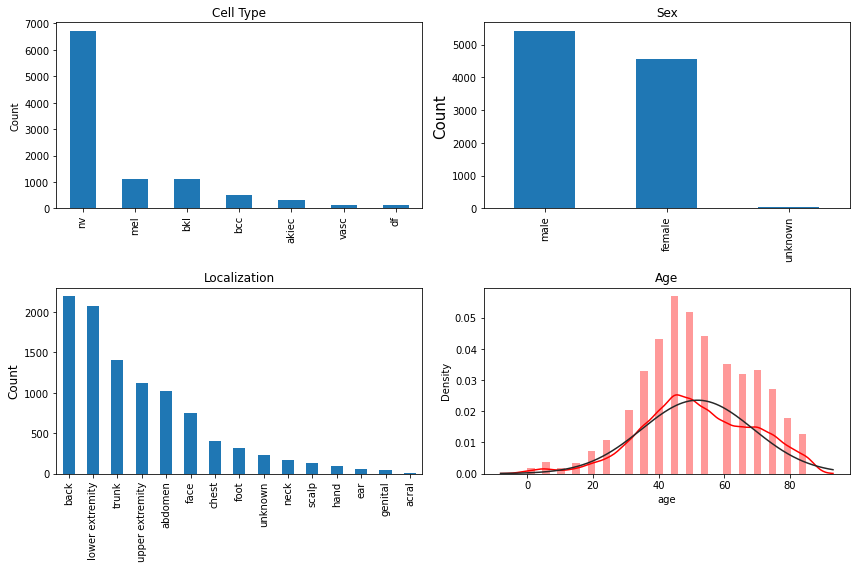

In [5]:
# Data distribution visualization
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()


In [6]:
# Distribution of data into various classes 
from sklearn.utils import resample
print(skin_df['label'].value_counts())


5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


In [7]:
#Balance data.
# Many ways to balance data... you can also try assigning weights during model.fit
#Separate each classes, resample, and combine back into single dataframe

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)


In [8]:
#Combined back to a single dataframe
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

#Check the distribution. All classes should be balanced now.
print(skin_df_balanced['label'].value_counts())

0    500
2    500
4    500
6    500
1    500
3    500
5    500
Name: label, dtype: int64


In [9]:
# tmp_dir=glob(os.path.join('HAM10000','all_images','*.jpg'))
# tmp_dir

glob(os.path.join('all_images', '*.jpg'))


['all_images\\ISIC_0024306.jpg',
 'all_images\\ISIC_0024307.jpg',
 'all_images\\ISIC_0024308.jpg',
 'all_images\\ISIC_0024309.jpg',
 'all_images\\ISIC_0024310.jpg',
 'all_images\\ISIC_0024311.jpg',
 'all_images\\ISIC_0024312.jpg',
 'all_images\\ISIC_0024313.jpg',
 'all_images\\ISIC_0024314.jpg',
 'all_images\\ISIC_0024315.jpg',
 'all_images\\ISIC_0024316.jpg',
 'all_images\\ISIC_0024317.jpg',
 'all_images\\ISIC_0024318.jpg',
 'all_images\\ISIC_0024319.jpg',
 'all_images\\ISIC_0024320.jpg',
 'all_images\\ISIC_0024321.jpg',
 'all_images\\ISIC_0024322.jpg',
 'all_images\\ISIC_0024323.jpg',
 'all_images\\ISIC_0024324.jpg',
 'all_images\\ISIC_0024325.jpg',
 'all_images\\ISIC_0024326.jpg',
 'all_images\\ISIC_0024327.jpg',
 'all_images\\ISIC_0024328.jpg',
 'all_images\\ISIC_0024329.jpg',
 'all_images\\ISIC_0024330.jpg',
 'all_images\\ISIC_0024331.jpg',
 'all_images\\ISIC_0024332.jpg',
 'all_images\\ISIC_0024333.jpg',
 'all_images\\ISIC_0024334.jpg',
 'all_images\\ISIC_0024335.jpg',
 'all_imag

In [10]:
#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(r'all_images', '*.jpg'))}

# image_path

In [11]:
import os
os.getcwd()

'D:\\Harshil\\My_work\\ML\\Data\\HAM10000'

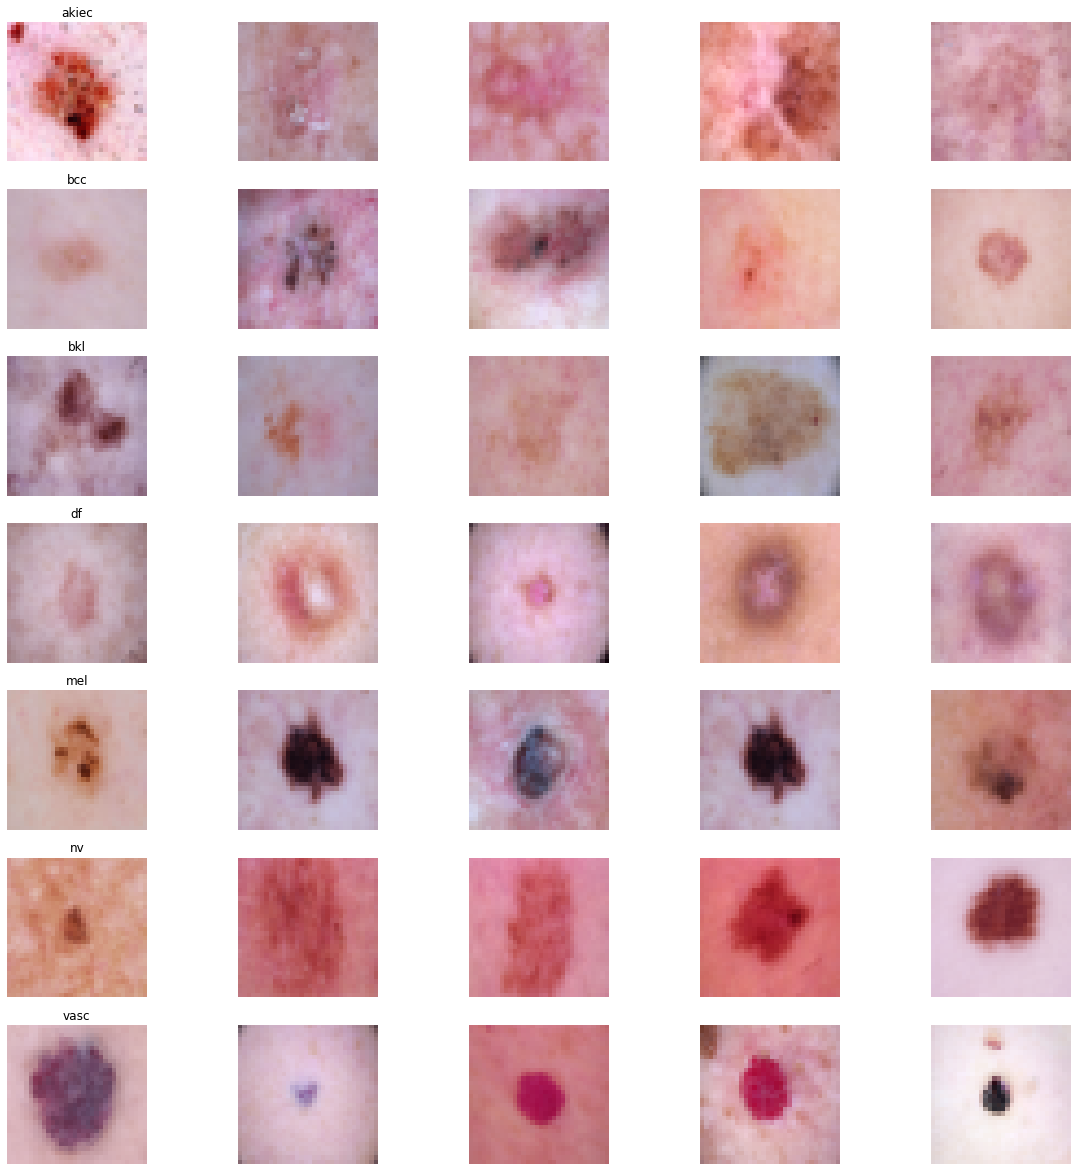

In [12]:
#Define the path and add as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))


n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [13]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem

In [14]:
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.2, random_state=42)

In [15]:
###Model
num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 256)       7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 128)       295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          7

In [16]:
# Train
#You can also use generator to use augmentation during training.

batch_size = 16 
epochs = 50

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

Epoch 1/50
175/175 - 5s - loss: 1.8778 - acc: 0.2079 - val_loss: 1.8722 - val_acc: 0.2071
Epoch 2/50
175/175 - 1s - loss: 1.7106 - acc: 0.2786 - val_loss: 1.7603 - val_acc: 0.2757
Epoch 3/50
175/175 - 1s - loss: 1.5321 - acc: 0.3718 - val_loss: 1.6149 - val_acc: 0.3457
Epoch 4/50
175/175 - 1s - loss: 1.4781 - acc: 0.3929 - val_loss: 1.4651 - val_acc: 0.4200
Epoch 5/50
175/175 - 1s - loss: 1.3958 - acc: 0.4361 - val_loss: 1.3818 - val_acc: 0.4457
Epoch 6/50
175/175 - 1s - loss: 1.3620 - acc: 0.4696 - val_loss: 1.3586 - val_acc: 0.4357
Epoch 7/50
175/175 - 1s - loss: 1.3007 - acc: 0.4839 - val_loss: 1.3475 - val_acc: 0.4543
Epoch 8/50
175/175 - 1s - loss: 1.2764 - acc: 0.4925 - val_loss: 1.3201 - val_acc: 0.4957
Epoch 9/50
175/175 - 1s - loss: 1.2481 - acc: 0.5021 - val_loss: 1.2312 - val_acc: 0.5157
Epoch 10/50
175/175 - 1s - loss: 1.2209 - acc: 0.5211 - val_loss: 1.2456 - val_acc: 0.4686
Epoch 11/50
175/175 - 1s - loss: 1.2019 - acc: 0.5229 - val_loss: 1.2222 - val_acc: 0.5014
Epoch 12

In [17]:
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

22/22 [==============================] - 0s 13ms/step - loss: 0.7199 - acc: 0.7543
Test accuracy: 0.7542856931686401


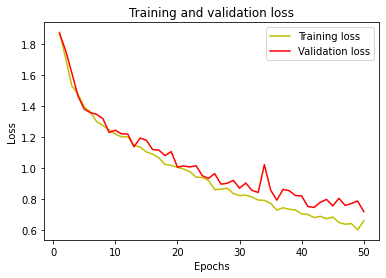

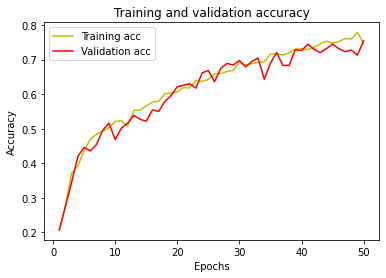

In [18]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

In [20]:
#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

In [21]:
cm

array([[99,  9,  9,  7,  2,  0,  0],
       [18, 63, 11,  9,  1,  2,  1],
       [15,  1, 58,  2, 14,  5,  0],
       [ 0,  4,  2, 95,  0,  0,  0],
       [ 4,  2, 11,  2, 64,  3,  1],
       [ 2,  4,  8,  4, 16, 52,  3],
       [ 0,  0,  0,  0,  0,  0, 97]], dtype=int64)

<AxesSubplot:>

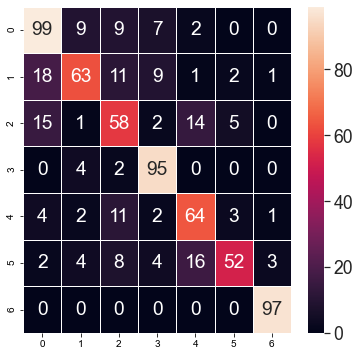

In [22]:
fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

Text(0, 0.5, 'Fraction of incorrect predictions')

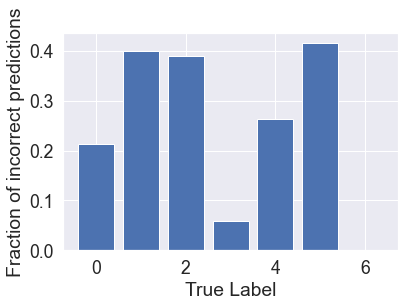

In [23]:
#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')



In [24]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (32, 32, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

In [25]:
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 

In [26]:
for layer in base_model.layers:
    layer.trainable = False

In [27]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='softmax')(x)

model_vgg = tf.keras.models.Model(base_model.input, x)

model_vgg.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3), loss = 'categorical_crossentropy',metrics = ['acc'])


In [28]:
vgghist = model_vgg.fit(x_train, y_train, steps_per_epoch = 50, epochs = 100)
# y_train.shapeO
# x_train.shape

Epoch 1/100
50/50 [==============================] - 3s 21ms/step - loss: 1.8102 - acc: 0.2952
Epoch 2/100
50/50 [==============================] - 1s 21ms/step - loss: 1.4119 - acc: 0.4765
Epoch 3/100
50/50 [==============================] - 1s 21ms/step - loss: 1.3353 - acc: 0.4873
Epoch 4/100
50/50 [==============================] - 1s 21ms/step - loss: 1.2513 - acc: 0.5270
Epoch 5/100
50/50 [==============================] - 1s 21ms/step - loss: 1.2085 - acc: 0.5458
Epoch 6/100
50/50 [==============================] - 1s 21ms/step - loss: 1.1461 - acc: 0.5709
Epoch 7/100
50/50 [==============================] - 1s 21ms/step - loss: 1.1171 - acc: 0.5773
Epoch 8/100
50/50 [==============================] - 1s 21ms/step - loss: 1.1316 - acc: 0.5626
Epoch 9/100
50/50 [==============================] - 1s 21ms/step - loss: 1.0963 - acc: 0.5831
Epoch 10/100
50/50 [==============================] - 1s 21ms/step - loss: 1.0509 - acc: 0.5947: 0s - loss: 1.0453 - acc: 
Epoch 11/100
50/50 [==

In [29]:
score = model_vgg.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

22/22 [==============================] - 2s 53ms/step - loss: 0.9347 - acc: 0.7471
Test accuracy: 0.7471428513526917


In [30]:
# Prediction on test data
y_pred = model_vgg.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

<AxesSubplot:>

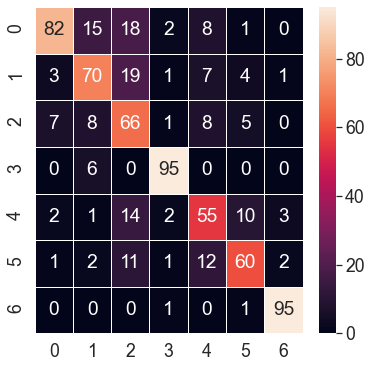

In [31]:
#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

Text(0, 0.5, 'Fraction of incorrect predictions')

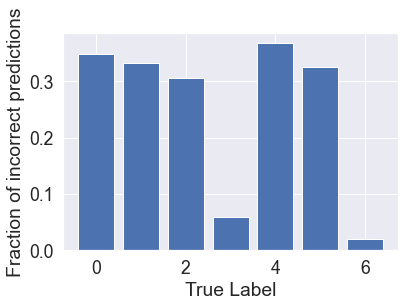

In [32]:
#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')


In [33]:
from tensorflow.keras.applications import efficientnet as efn
base_model = efn.EfficientNetB0(input_shape = (32, 32, 3), include_top = False, weights = 'imagenet')


In [34]:
for layer in base_model.layers:
    layer.trainable = False


In [35]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='softmax')(x)

model_efn = tf.keras.models.Model(base_model.input, x)

model_efn.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2), loss = 'categorical_crossentropy',metrics = ['acc'])


In [36]:
efnhist = model_efn.fit(x_train, y_train, steps_per_epoch = 50, epochs = 100)


Epoch 1/100
50/50 [==============================] - 10s 35ms/step - loss: 4.5668 - acc: 0.1539
Epoch 2/100
50/50 [==============================] - 2s 33ms/step - loss: 1.9537 - acc: 0.1483
Epoch 3/100
50/50 [==============================] - 2s 30ms/step - loss: 1.9463 - acc: 0.1376
Epoch 4/100
50/50 [==============================] - 1s 29ms/step - loss: 1.9462 - acc: 0.1369
Epoch 5/100
50/50 [==============================] - ETA: 0s - loss: 1.9462 - acc: 0.127 - 2s 34ms/step - loss: 1.9462 - acc: 0.1275
Epoch 6/100
50/50 [==============================] - 1s 29ms/step - loss: 1.9449 - acc: 0.1513
Epoch 7/100
50/50 [==============================] - 1s 29ms/step - loss: 1.9457 - acc: 0.1272
Epoch 8/100
50/50 [==============================] - 2s 34ms/step - loss: 1.9452 - acc: 0.1448
Epoch 9/100
50/50 [==============================] - 1s 29ms/step - loss: 1.9472 - acc: 0.1450
Epoch 10/100
50/50 [==============================] - 1s 28ms/step - loss: 1.9456 - acc: 0.1514
Epoch 11/1

In [37]:
acc=model_efn.evaluate(x_test,y_test)
print('Accuracy :',acc[1])

22/22 [==============================] - 4s 63ms/step - loss: 1.9495 - acc: 0.1243
Accuracy : 0.12428571283817291


In [42]:
x_train[0].shape

(32, 32, 3)

In [52]:
import cv2

img = cv2.imread('D:\Harshil\My_work\ML\Data\HAM10000\HAM10000_images_part_1\ISIC_0024307.jpg')

img = cv2.resize(img,(32,32))

img = np.reshape(img,[1,32,32,3])

classes = model_vgg.predict(img)

classes

array([[0., 0., 0., 0., 0., 0., 1.]], dtype=float32)